In [1]:
from cutqc.main import CutQC
from qiskit import *
import numpy as np

In [2]:
nq = 6
full_circ = QuantumCircuit(nq)
for i in range(nq-1):
    full_circ.cx(i, i+1)
full_circ.rx(np.pi, nq-1)
for i in range(nq-1,0,-1):
    full_circ.cx(i-1, i)
print(full_circ)

                                                                
q_0: ──■─────────────────────────────────────────────────────■──
     ┌─┴─┐                                                 ┌─┴─┐
q_1: ┤ X ├──■───────────────────────────────────────────■──┤ X ├
     └───┘┌─┴─┐                                       ┌─┴─┐└───┘
q_2: ─────┤ X ├──■─────────────────────────────────■──┤ X ├─────
          └───┘┌─┴─┐                             ┌─┴─┐└───┘     
q_3: ──────────┤ X ├──■───────────────────────■──┤ X ├──────────
               └───┘┌─┴─┐                   ┌─┴─┐└───┘          
q_4: ───────────────┤ X ├──■─────────────■──┤ X ├───────────────
                    └───┘┌─┴─┐┌───────┐┌─┴─┐└───┘               
q_5: ────────────────────┤ X ├┤ RX(π) ├┤ X ├────────────────────
                         └───┘└───────┘└───┘                    


In [3]:
max_subcircuit_qubit = 4
num_subcircuits = [2]
max_cuts = 2
verbose = 2

circuits = {'my_circ':full_circ}

cutqc = CutQC(circuits, max_subcircuit_qubit, num_subcircuits, max_cuts, verbose)

## Prior functionality:
The code below will no longer execute because I've changed the CutQC `__init__` function so it does *not* immediately call `_cut()`

However, the output shows how the circuit above should be partitioned

In [10]:
cutsoln = cutqc.cut_solns[0]
print(cutsoln.keys())
for i, subcirc in enumerate(cutsoln['subcircuits']):
    print('Subcircuit', i)
    print(subcirc)

dict_keys(['circuit', 'max_subcircuit_qubit', 'subcircuits', 'complete_path_map', 'searcher_time', 'num_rho_qubits', 'num_O_qubits', 'num_d_qubits', 'objective', 'positions', 'counter', 'cost_estimate'])
Subcircuit 0
                         
q_0: ──■──────────────■──
     ┌─┴─┐          ┌─┴─┐
q_1: ┤ X ├──■────■──┤ X ├
     └───┘┌─┴─┐  │  └───┘
q_2: ─────┤ X ├──┼───────
          └───┘┌─┴─┐     
q_3: ──────────┤ X ├─────
               └───┘     
Subcircuit 1
                                            
q_0: ──■─────────────────────────────────■──
     ┌─┴─┐                             ┌─┴─┐
q_1: ┤ X ├──■───────────────────────■──┤ X ├
     └───┘┌─┴─┐                   ┌─┴─┐└───┘
q_2: ─────┤ X ├──■─────────────■──┤ X ├─────
          └───┘┌─┴─┐┌───────┐┌─┴─┐└───┘     
q_3: ──────────┤ X ├┤ RX(π) ├┤ X ├──────────
               └───┘└───────┘└───┘          


## New functionality:
Now, instead of calling `_cut()` which would *find* and *cut* the circuit we first solve the MIP model for the initial circuit.
Solving this model will use the Gurobi optimizer to find the best cut locations given our constrains. We'll then use this same model
to repeatedly cut circuits which have identical structure up to the values of their parametrized rotation gates.

In [4]:
mip_model = cutqc.get_MIP_model(max_subcircuit_qubit, num_subcircuits, max_cuts)
mip_model.subcircuits_vertices

Using license file /Users/teague/gurobi.lic
Academic license - for non-commercial use only


[['q[0]0 q[1]0', 'q[1]1 q[2]0', 'q[1]2 q[2]3', 'q[0]1 q[1]3'],
 ['q[2]1 q[3]0',
  'q[3]1 q[4]0',
  'q[4]1 q[5]0',
  'q[4]2 q[5]1',
  'q[3]2 q[4]3',
  'q[2]2 q[3]3']]

In [6]:
subcircs, cpm = cutqc.get_subcircs_from_model(full_circ, mip_model)
for i, subcirc in enumerate(subcircs):
    print('Subcirc', i)
    print(subcirc)

Subcirc 0
                         
q_0: ──■──────────────■──
     ┌─┴─┐          ┌─┴─┐
q_1: ┤ X ├──■────■──┤ X ├
     └───┘┌─┴─┐  │  └───┘
q_2: ─────┤ X ├──┼───────
          └───┘┌─┴─┐     
q_3: ──────────┤ X ├─────
               └───┘     
Subcirc 1
                                            
q_0: ──■─────────────────────────────────■──
     ┌─┴─┐                             ┌─┴─┐
q_1: ┤ X ├──■───────────────────────■──┤ X ├
     └───┘┌─┴─┐                   ┌─┴─┐└───┘
q_2: ─────┤ X ├──■─────────────■──┤ X ├─────
          └───┘┌─┴─┐┌───────┐┌─┴─┐└───┘     
q_3: ──────────┤ X ├┤ RX(π) ├┤ X ├──────────
               └───┘└───────┘└───┘          


In [7]:
nq = 6
full_circ2 = QuantumCircuit(nq)
for i in range(nq-1):
    full_circ2.cx(i, i+1)
full_circ2.rx(2*np.pi, nq-1)
for i in range(nq-1,0,-1):
    full_circ2.cx(i-1, i)
print(full_circ2)

                                                                 
q_0: ──■──────────────────────────────────────────────────────■──
     ┌─┴─┐                                                  ┌─┴─┐
q_1: ┤ X ├──■────────────────────────────────────────────■──┤ X ├
     └───┘┌─┴─┐                                        ┌─┴─┐└───┘
q_2: ─────┤ X ├──■──────────────────────────────────■──┤ X ├─────
          └───┘┌─┴─┐                              ┌─┴─┐└───┘     
q_3: ──────────┤ X ├──■────────────────────────■──┤ X ├──────────
               └───┘┌─┴─┐                    ┌─┴─┐└───┘          
q_4: ───────────────┤ X ├──■──────────────■──┤ X ├───────────────
                    └───┘┌─┴─┐┌────────┐┌─┴─┐└───┘               
q_5: ────────────────────┤ X ├┤ RX(2π) ├┤ X ├────────────────────
                         └───┘└────────┘└───┘                    


In [8]:
subcircs, cpm = cutqc.get_subcircs_from_model(full_circ2, mip_model)
for i, subcirc in enumerate(subcircs):
    print('Subcirc', i)
    print(subcirc)

Subcirc 0
                         
q_0: ──■──────────────■──
     ┌─┴─┐          ┌─┴─┐
q_1: ┤ X ├──■────■──┤ X ├
     └───┘┌─┴─┐  │  └───┘
q_2: ─────┤ X ├──┼───────
          └───┘┌─┴─┐     
q_3: ──────────┤ X ├─────
               └───┘     
Subcirc 1
                                             
q_0: ──■──────────────────────────────────■──
     ┌─┴─┐                              ┌─┴─┐
q_1: ┤ X ├──■────────────────────────■──┤ X ├
     └───┘┌─┴─┐                    ┌─┴─┐└───┘
q_2: ─────┤ X ├──■──────────────■──┤ X ├─────
          └───┘┌─┴─┐┌────────┐┌─┴─┐└───┘     
q_3: ──────────┤ X ├┤ RX(2π) ├┤ X ├──────────
               └───┘└────────┘└───┘          


## Test this with DQVA circuits

In [10]:
from cutDQVA import gen_dqva
import networkx as nx

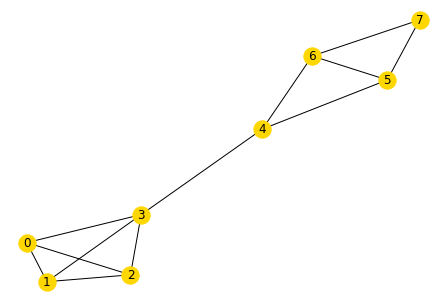

In [11]:
G = nx.Graph()
G.add_edges_from([(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3), (3, 4), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7)])
nx.draw_spring(G, with_labels=True, node_color='gold')

In [13]:
nq = len(G.nodes)
kl_bisection = ({0,1,2,3}, {4,5,6,7})
params = list(range(1, 2*nq+1+1))
print(params)
cur_init_state = '0'*nq
cur_permutation = list(range(nq))
print(cur_permutation)
hotnode = 3
dqva_circ1 = gen_dqva(G, kl_bisection, params=params, init_state=cur_init_state,
                      cut=True, mixer_order=cur_permutation, verbose=0,
                      decompose_toffoli=2, barriers=0, hot_nodes=[hotnode])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[0, 1, 2, 3, 4, 5, 6, 7]


In [14]:
max_subcircuit_qubit = 7
num_subcircuits = [2]
max_cuts = 4
verbose = 2

circuits = {'my_circ':dqva_circ1}

cutqc = CutQC(circuits, max_subcircuit_qubit, num_subcircuits, max_cuts,
              verbose)

In [15]:
mip_model = cutqc.get_MIP_model(max_subcircuit_qubit, num_subcircuits, max_cuts)
mip_model.subcircuits_vertices

[['q[3]0 anc[0]0',
  'q[3]1 anc[0]1',
  'q[3]2 q[2]0',
  'q[2]1 anc[0]2',
  'q[2]2 anc[0]3',
  'q[3]3 q[2]3',
  'q[2]4 anc[0]4',
  'q[2]5 anc[0]5',
  'q[2]6 q[1]0',
  'q[1]1 anc[0]6',
  'q[1]2 anc[0]7',
  'q[3]4 q[1]3',
  'q[1]4 anc[0]8',
  'q[1]5 anc[0]9',
  'q[2]7 q[1]6',
  'q[1]7 anc[0]10',
  'q[1]8 anc[0]11',
  'q[3]5 q[1]9',
  'q[1]10 anc[0]12',
  'q[1]11 anc[0]13',
  'anc[0]14 q[0]0',
  'q[3]6 anc[0]15',
  'q[3]7 anc[0]16',
  'q[3]8 q[2]8',
  'q[2]9 anc[0]17',
  'q[2]10 anc[0]18',
  'q[3]9 q[2]11',
  'q[2]12 anc[0]19',
  'q[2]13 anc[0]20',
  'q[2]14 q[1]12',
  'q[1]13 anc[0]21',
  'q[1]14 anc[0]22',
  'q[3]10 q[1]15',
  'q[1]16 anc[0]23',
  'q[1]17 anc[0]24',
  'q[2]15 q[1]18',
  'q[1]19 anc[0]25',
  'q[1]20 anc[0]26',
  'q[3]11 q[1]21',
  'q[1]22 anc[0]27',
  'q[1]23 anc[0]28',
  'q[3]12 anc[0]29',
  'q[3]13 anc[0]30',
  'q[3]14 q[2]16',
  'q[2]17 anc[0]31',
  'q[2]18 anc[0]32',
  'q[3]15 q[2]19',
  'q[2]20 anc[0]33',
  'q[2]21 anc[0]34',
  'q[2]22 q[0]1',
  'q[0]2 anc[0]35',
  

In [41]:
def print_params(circ):
    qasm = circ.qasm().split('\n')
    params = []
    for line in qasm:
        if 'crx' in line:
            p = line.split('(')[1].split(')')[0]
            params.append(p)
    print('params:', *params)

In [48]:
subcircs, cpm = cutqc.get_subcircs_from_model(dqva_circ1, mip_model)
for i, subcirc in enumerate(subcircs):
    print('Subcirc', i)
    #print(subcirc.draw(fold=150))
    print(len(subcirc.qubits), 'qubits')
    print(subcirc.count_ops())
    print_params(subcirc)
    print()

Subcirc 0
7 qubits
OrderedDict([('u1', 432), ('cx', 416), ('x', 104), ('h', 32), ('crx', 8), ('rz', 4)])
params: 2 4 6 8 20 22 24 26

Subcirc 1
6 qubits
OrderedDict([('cx', 184), ('u1', 168), ('x', 64), ('h', 24), ('t', 16), ('tdg', 12), ('crx', 6), ('rz', 4)])
params: 12 14 16 30 32 34



In [51]:
params = list(range(1, 2*nq+1+1))
params = [p + 1 for p in params]
print(params)
print(cur_permutation)
hotnode = 3
dqva_circ2 = gen_dqva(G, kl_bisection, params=params, init_state=cur_init_state,
                      cut=True, mixer_order=cur_permutation, verbose=0,
                      decompose_toffoli=2, barriers=0, hot_nodes=[hotnode])

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 5, 6, 7]


In [52]:
subcircs, cpm = cutqc.get_subcircs_from_model(dqva_circ2, mip_model)
for i, subcirc in enumerate(subcircs):
    print('Subcirc', i)
    #print(subcirc.draw(fold=150))
    print(len(subcirc.qubits), 'qubits')
    print(subcirc.count_ops())
    print_params(subcirc)
    print()

Subcirc 0
7 qubits
OrderedDict([('u1', 432), ('cx', 416), ('x', 104), ('h', 32), ('crx', 8), ('rz', 4)])
params: 4 6 8 10 22 24 26 28

Subcirc 1
6 qubits
OrderedDict([('cx', 184), ('u1', 168), ('x', 64), ('h', 24), ('t', 16), ('tdg', 12), ('crx', 6), ('rz', 4)])
params: 14 16 18 32 34 36



In [54]:
params = list(range(1, 2*nq+1+1))
params = [p * 0.1 for p in params]
print(params)
print(cur_permutation)
hotnode = 3
dqva_circ3 = gen_dqva(G, kl_bisection, params=params, init_state=cur_init_state,
                      cut=True, mixer_order=cur_permutation, verbose=0,
                      decompose_toffoli=2, barriers=0, hot_nodes=[hotnode])

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3, 1.4000000000000001, 1.5, 1.6, 1.7000000000000002]
[0, 1, 2, 3, 4, 5, 6, 7]


In [55]:
subcircs, cpm = cutqc.get_subcircs_from_model(dqva_circ3, mip_model)
for i, subcirc in enumerate(subcircs):
    print('Subcirc', i)
    #print(subcirc.draw(fold=150))
    print(len(subcirc.qubits), 'qubits')
    print(subcirc.count_ops())
    print_params(subcirc)
    print()

Subcirc 0
7 qubits
OrderedDict([('u1', 432), ('cx', 416), ('x', 104), ('h', 32), ('crx', 8), ('rz', 4)])
params: 0.2 0.4 0.6 0.8 2 2.2 2.4 2.6

Subcirc 1
6 qubits
OrderedDict([('cx', 184), ('u1', 168), ('x', 64), ('h', 24), ('t', 16), ('tdg', 12), ('crx', 6), ('rz', 4)])
params: 1.2 1.4 1.6 3 3.2 3.4

